In [1]:
import torch
import mlflow
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from genhack.utils import *
import math
from types import MethodType


In [2]:
# df = pd.read_csv('data/df_all.csv')
# df = df.set_index('dates')
# _, df = train_test_split(df, shuffle=False, test_size=0.25)

df = pd.read_csv('data/df_test.csv')
df = df.set_index('dates')

In [3]:
noise = torch.randn((df.shape[0], 7))
model = mlflow.pytorch.load_model('parameters/20221203/best_ad_mean')

In [6]:
def sample(self, noise, t_min=0.75, t_max=1.):
    
    # add constant trend instead
    print(self.ts_model.coef)
    self.ts_model.coef.copy_(torch.full((6,), 1.1))

    # noise and time samples
    norm_cdf = lambda x: 0.5 * (1 + torch.erf(x / math.sqrt(2)))
    time = t_min + (t_max - t_min) * norm_cdf(noise[:, 6])
    noise = noise[:, :6]

    samples = torch.squeeze(self.flow._transform.inverse(noise)[0])

    # entrend
    # @todo currently we have ts_model + generative_model
    # one should consider conditional models too
    if self.ts_model is not None:
        samples += self.ts_model(time)

    return samples
            
model.sample = MethodType(sample, model)

In [7]:
X_pred = model.sample(noise)
X_test = torch.tensor(df.to_numpy())

Parameter containing:
tensor([0.5584, 0.4592, 0.8271, 0.7801, 0.8870, 1.3649])


In [8]:
anderson_darling(X_test, X_pred), kendall_absolute_error(X_test, X_pred)

((tensor([166.2146, 121.8838,  47.7712, 270.9170,  14.9719, 272.1187]),
  tensor(148.9795)),
 tensor(0.0061))

In [9]:
model.ts_model.coef

Parameter containing:
tensor([1.1000, 1.1000, 1.1000, 1.1000, 1.1000, 1.1000])

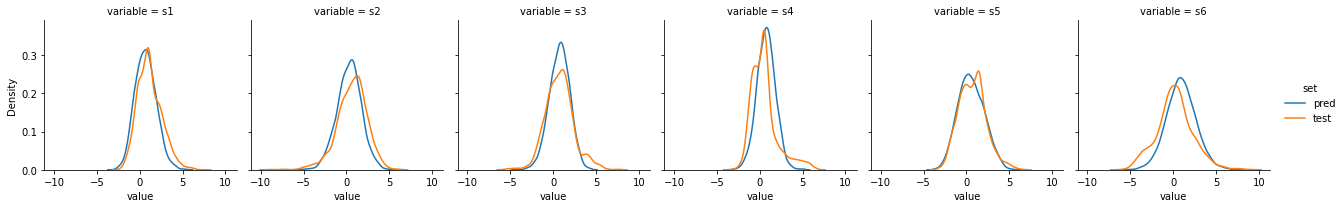

In [10]:
df_pred = pd.DataFrame(X_pred.detach().numpy(), columns=['s1', 's2', 's3', 's4', 's5', 's6'])
df_pred['set'] = 'pred'

df_test = pd.DataFrame(X_test.detach().numpy(), columns=['s1', 's2', 's3', 's4', 's5', 's6'])
df_test['set'] = 'test'

g = sns.FacetGrid(pd.melt(pd.concat([df_pred, df_test]), id_vars=['set'], value_vars=['s1', 's2', 's3', 's4', 's5', 's6']), hue='set', col='variable')
g.map(sns.kdeplot, 'value')
g.add_legend()